# Inflation of Billable Resources

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from collections import OrderedDict
import matplotlib as mpl
import seaborn as sns
import os
import gc

In [2]:
print("="*80)
print("Inflation of Billable Resources")
print("-"*80)

Inflation of Billable Resources
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Traces

In [4]:
# Get trace data dir from CURRENT_DIR/../data.env
with open( '../data.env') as f:
    for line in f:
        if line.startswith('TRACE_DATA_DIR'):
            TRACE_DATA_DIR = line.split('=')[1].strip()
            break
TRACES_PATH = os.path.join(TRACE_DATA_DIR, 'public_request_tables')

In [5]:
TRACES_PATH = os.path.join(TRACES_PATH, 'huawei_25_traces_public_request_tables.pkl')

In [6]:
with open(TRACES_PATH, "rb") as f:
    traces = pickle.load(f)

In [7]:
traces.shape

(793999482, 9)

In [8]:
traces.head(5)

,podID,runtimeCost,cpu_usage,memory_usage,cpu_cores,memory_mb,relative_cpu_usage,relative_memory_usage,cpu_time
0,pool24-600-512-0004546402,0.058268,0.600000,313.187500,0.6,512,1.000000,0.611694,0.034961
1,pool22-300-128-0003702527,0.334085,0.098253,49.406250,0.3,128,0.327510,0.385986,0.032825
2,pool26-1000-1024-0001996304,0.183630,0.174525,51.027344,1.0,1024,0.174525,0.049831,0.032048
3,pool24-600-512-0006653892,0.047347,0.433650,307.187500,0.6,512,0.722750,0.599976,0.020532
4,pool22-300-128-0004007403,0.184775,0.152065,45.281250,0.3,128,0.506883,0.353760,0.028098


In [9]:
# exclude them as we are unsure whether the cause was Huawei telemetry limitations
traces = traces[traces["cpu_time"] != 0.0]
print("trace shape:", traces.shape)

trace shape: (558735833, 9)


## Helper Functions

In [10]:
def compute_cdf_percentiles(arr, percentiles=None):
    """
    Compute CDF using percentiles - much faster for large datasets.
    
    Args:
        arr: Input array
        percentiles: Array of percentile values (0-100). If None, uses p0 to p100
    
    Returns:
        x_vals, cdf_vals: Arrays for plotting
    """
    # Remove non-finite values efficiently
    finite_mask = np.isfinite(arr)
    if not np.any(finite_mask):
        return np.array([]), np.array([])
    
    clean = arr[finite_mask]
    
    if percentiles is None:
        percentiles = np.arange(0, 101, 1)  # 0, 1, 2, ..., 100
    
    # Calculate percentile values
    x_vals = np.percentile(clean, percentiles)
    # Convert percentiles to CDF values (0-1 scale)
    cdf_vals = percentiles / 100.0
    
    return x_vals, cdf_vals

## Billables Calculation

In [11]:
billables_data = {}

### Actual Usage

In [12]:
print("Processing Actual Usage...")

Processing Actual Usage...


In [13]:
billable_time_ms = traces['runtimeCost'].to_numpy() * 1000
billable_memory_mb = traces['memory_usage'].to_numpy()
billable_memory_mbms = billable_memory_mb * billable_time_ms

billable_vcpus_ms = traces['cpu_time'].to_numpy() * 1000
billable_memory_mbms = billable_memory_mbms

billables_data['Actual Usage'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

### Huawei
* Use original config
* Wall Time Rounding: 1ms
* References
    * https://support.huaweicloud.com/eu/functiongraph/index.html
    * https://support.huaweicloud.com/eu/price-functiongraph/functiongraph_00_0004.html

In [14]:
print("Processing Huawei...")

Processing Huawei...


In [15]:
def calculate_billables_huawei(exec_duration_ms,
                              allocated_memory_mb,
                              allocated_vcpus,
                              consumed_memory_mb,
                              cpu_time_ms):
    exec_duration_ms      = np.asarray(exec_duration_ms,      dtype=float)
    allocated_memory_mb   = np.asarray(allocated_memory_mb,   dtype=float)
    allocated_vcpus       = np.asarray(allocated_vcpus,       dtype=float)

    billable_time_ms = np.ceil(exec_duration_ms).astype(int)

    billable_vcpus_ms    = allocated_vcpus     * billable_time_ms
    billable_memory_mbms = allocated_memory_mb * billable_time_ms

    return billable_vcpus_ms, billable_memory_mbms

In [16]:
exec_ms      = traces['runtimeCost'].values * 1000
mem_mb       = traces['memory_mb'].values
cpu_cores    = traces['cpu_cores'].values

billable_vcpus_ms, billable_memory_mbms = calculate_billables_huawei(
    exec_duration_ms    = exec_ms,
    allocated_memory_mb = mem_mb,
    allocated_vcpus     = cpu_cores,
    consumed_memory_mb  = None,
    cpu_time_ms         = None
)

billables_data['Huawei'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

### Proportional CPU Allocation (AWS)

In [17]:
print("Processing Proportional CPU Allocation (AWS)...")

Processing Proportional CPU Allocation (AWS)...


In [18]:
# calculate the average cpu to memory ratio in huawei traces
pod_flavors = set(zip(traces['cpu_cores'].values, traces['memory_mb'].values))
allocated_cpu_to_memory_size_ratios = [x*1000 / y for x, y in pod_flavors]
average_allocated_cpu_to_memory_size_ratios_mc_per_mb = np.mean(allocated_cpu_to_memory_size_ratios)

def calculate_billables_proportional(exec_duration_ms,
                                     allocated_memory_mb,
                                     allocated_vcpus,
                                     consumed_memory_mb,
                                     cpu_time_ms,
                                     average_allocated_cpu_to_memory_size_ratios_mc_per_mb):
    exec_duration_ms      = np.asarray(exec_duration_ms,      dtype=float)
    allocated_memory_mb   = np.asarray(allocated_memory_mb,   dtype=float)
    allocated_vcpus       = np.asarray(allocated_vcpus,       dtype=float)

    billable_time_ms = np.ceil(exec_duration_ms).astype(int)

    ratio = average_allocated_cpu_to_memory_size_ratios_mc_per_mb
    initial_vcpu_alloc = ratio * allocated_memory_mb / 1000.0

    # use whichever larger as the base to calibrate billables
    billable_vcpu_allocation = np.maximum(initial_vcpu_alloc, allocated_vcpus)
    billable_memory_mb = np.where(
        initial_vcpu_alloc < allocated_vcpus,
        billable_vcpu_allocation * 1000.0 / ratio,
        allocated_memory_mb
    )


    billable_vcpus_ms    = billable_vcpu_allocation * billable_time_ms
    billable_memory_mbms = billable_memory_mb       * billable_time_ms

    return billable_vcpus_ms, billable_memory_mbms

In [19]:
exec_ms      = traces['runtimeCost'].values * 1000
mem_mb       = traces['memory_mb'].values
cpu_cores    = traces['cpu_cores'].values

billable_vcpus_ms, billable_memory_mbms = calculate_billables_proportional(
    exec_duration_ms    = exec_ms,
    allocated_memory_mb = mem_mb,
    allocated_vcpus     = cpu_cores,
    consumed_memory_mb  = None,
    cpu_time_ms         = None,
    average_allocated_cpu_to_memory_size_ratios_mc_per_mb = average_allocated_cpu_to_memory_size_ratios_mc_per_mb
)

billables_data['Proportional'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

### Wall Time Rounding (GCP)

In [20]:
print("Processing Wall Time Rounding (GCP)...")

Processing Wall Time Rounding (GCP)...


In [21]:
def calculate_billables_wctrounding(exec_duration_ms,
                              allocated_memory_mb,
                              allocated_vcpus,
                              consumed_memory_mb,
                              cpu_time_ms):
    
    exec_duration_ms      = np.asarray(exec_duration_ms,      dtype=float)
    allocated_memory_mb   = np.asarray(allocated_memory_mb,   dtype=float)
    allocated_vcpus       = np.asarray(allocated_vcpus,       dtype=float)

    # round up to the nearest 100ms
    billable_time_ms = np.ceil(exec_duration_ms / 100) * 100


    billable_vcpus_ms    = allocated_vcpus     * billable_time_ms
    billable_memory_mbms = allocated_memory_mb * billable_time_ms

    return billable_vcpus_ms, billable_memory_mbms

In [22]:
exec_ms      = traces['runtimeCost'].values * 1000
mem_mb       = traces['memory_mb'].values
cpu_cores    = traces['cpu_cores'].values

billable_vcpus_ms, billable_memory_mbms = calculate_billables_wctrounding(
    exec_duration_ms    = exec_ms,
    allocated_memory_mb = mem_mb,
    allocated_vcpus     = cpu_cores,
    consumed_memory_mb  = None,
    cpu_time_ms         = None
)

billables_data['WCT Rounding'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

### Time and Usage Rounding (Azure Consumption)

In [23]:
print("Processing Time and Usage Rounding (Azure Consumption)...")

Processing Time and Usage Rounding (Azure Consumption)...


In [24]:
def calculate_billables_usagerounding(exec_duration_ms,
                                      allocated_memory_mb,
                                      allocated_vcpus,
                                      consumed_memory_mb,
                                      cpu_time_ms):
    # Convert inputs to numpy arrays
    exec_duration_ms    = np.asarray(exec_duration_ms,    dtype=float)
    allocated_vcpus     = np.asarray(allocated_vcpus,     dtype=float)
    consumed_memory_mb  = np.asarray(consumed_memory_mb,  dtype=float)

    billable_time_ms = np.where(
        exec_duration_ms < 100,
        100,
        np.ceil(exec_duration_ms)
    ).astype(int)

    billable_memory_mb = (np.ceil(consumed_memory_mb / 128)).astype(int) * 128

    billable_vcpus_ms    = allocated_vcpus     * billable_time_ms
    billable_memory_mbms = billable_memory_mb  * billable_time_ms

    return billable_vcpus_ms, billable_memory_mbms

In [25]:
exec_ms      = traces['runtimeCost'].values * 1000
mem_mb       = traces['memory_mb'].values
cpu_cores    = traces['cpu_cores'].values
consumed_memory_mb = traces['memory_usage'].values

billable_vcpus_ms, billable_memory_mbms = calculate_billables_usagerounding(
    exec_duration_ms    = exec_ms,
    allocated_memory_mb = mem_mb,
    allocated_vcpus     = cpu_cores,
    consumed_memory_mb  = consumed_memory_mb,
    cpu_time_ms         = None
)

billables_data['Usg Rounding'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

### CPU Time Only (Cloudflare)

In [26]:
print("Processing CPU Time Only (Cloudflare)...")

Processing CPU Time Only (Cloudflare)...


In [27]:
def calculate_billables_cputime(exec_duration_ms,
                              allocated_memory_mb,
                              allocated_vcpus,
                              consumed_memory_mb,
                              cpu_time_ms):
    
    exec_duration_ms      = np.asarray(exec_duration_ms,      dtype=float)
    allocated_memory_mb   = np.asarray(allocated_memory_mb,   dtype=float)
    allocated_vcpus       = np.asarray(allocated_vcpus,       dtype=float)
    consumed_memory_mb    = np.asarray(consumed_memory_mb,    dtype=float)
    cpu_time_ms           = np.asarray(cpu_time_ms,           dtype=float)

    billable_vcpus_ms    = np.ceil(cpu_time_ms).astype(int)
    billable_memory_mbms = np.array([0] * len(cpu_time_ms), dtype=float)

    return billable_vcpus_ms, billable_memory_mbms

In [28]:
exec_ms      = traces['runtimeCost'].values * 1000
mem_mb       = traces['memory_mb'].values
cpu_cores    = traces['cpu_cores'].values
consumed_memory_mb = traces['memory_usage'].values
cpu_time_ms = traces['cpu_time'].values * 1000

billable_vcpus_ms, billable_memory_mbms = calculate_billables_cputime(
    exec_duration_ms    = None,
    allocated_memory_mb = None,
    allocated_vcpus     = None,
    consumed_memory_mb  = None,
    cpu_time_ms         = cpu_time_ms
)

billables_data['CPU Time'] = {
    'vCPUs':  {
        "mean": np.mean(billable_vcpus_ms),
        "percentiles": compute_cdf_percentiles(billable_vcpus_ms)
    },
    'Memory': {
        "mean": np.mean(billable_memory_mbms),
        "percentiles": compute_cdf_percentiles(billable_memory_mbms)
    }
}

## Plotting

In [29]:
processed_data_dir = os.path.join(TRACE_DATA_DIR, 'processed_data')
os.makedirs(processed_data_dir, exist_ok=True)
processed_data_path = os.path.join(processed_data_dir, 'billables_data.pkl')

In [30]:
with open(processed_data_path, "wb") as f:
    pickle.dump(billables_data, f)

In [31]:
# with open(processed_data_path, "rb") as f:
#     billables_data = pickle.load(f)

In [32]:
# convert to vCPU-Seconds and GB-Seconds
for k, v in billables_data.items():
    v['vCPUs'] = {
        'mean': v['vCPUs']['mean'] / 1000,
        'percentiles': (v['vCPUs']['percentiles'][0] / 1000, v['vCPUs']['percentiles'][1])
    }
    v['Memory'] = {
        'mean': v['Memory']['mean'] / 1024 / 1000,
        'percentiles': (v['Memory']['percentiles'][0] / 1024 / 1000, v['Memory']['percentiles'][1])
    }

Processing CPU data...
  Processing Actual Usage...
  Processing Huawei (Fixed Combo)...
  Processing AWS (Proportional)...
  Processing GCP (Time Rnd)...
  Processing Azure (Time and Usg Rnd)...
  Processing Cloudflare (CPU Time)...
Processing Memory data...
  Processing Actual Usage...
  Processing Huawei (Fixed Combo)...
  Processing AWS (Proportional)...
  Processing GCP (Time Rnd)...
  Processing Azure (Time and Usg Rnd)...
  Processing Cloudflare (CPU Time)...
Creating legend...
Saving figure...
Figure saved to figures/billables_cdf_current_billing.pdf


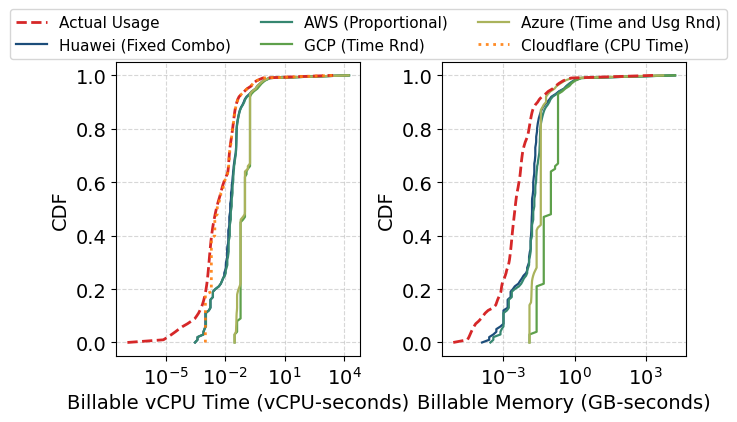

In [ ]:

def plot_cdf_percentiles(ax, arr, label, percentiles=None, **plot_kwargs):
    """Plot CDF using percentile calculation."""
    x_vals, cdf_vals = arr['percentiles'][0], arr['percentiles'][1]
    if len(x_vals) > 0:
        ax.plot(x_vals, cdf_vals, label=label, **plot_kwargs)

arrays_cpu = [
    billables_data['Actual Usage']['vCPUs'],
    billables_data['Huawei']['vCPUs'],
    billables_data['Proportional']['vCPUs'],
    billables_data['WCT Rounding']['vCPUs'],
    billables_data['Usg Rounding']['vCPUs'],
    billables_data['CPU Time']['vCPUs'],
]

arrays_mem = [
    billables_data['Actual Usage']['Memory'],
    billables_data['Huawei']['Memory'],
    billables_data['Proportional']['Memory'],
    billables_data['WCT Rounding']['Memory'],
    billables_data['Usg Rounding']['Memory'],
    billables_data['CPU Time']['Memory'],
]

labels = ['Actual Usage',
          'Huawei (Fixed Combo)',
          'AWS (Proportional)',
          'GCP (Time Rnd)',
          'Azure (Time and Usg Rnd)',
          'Cloudflare (CPU Time)']

sns_palette_labels = [label for label in labels 
                     if label not in ['Actual Usage', 'Cloudflare (CPU Time)']]
palette = sns.color_palette("gist_earth", n_colors=len(sns_palette_labels)+1)
color_map = {system: palette[idx] for idx, system in enumerate(sns_palette_labels)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.65, 3.8))

percentiles = np.arange(0, 101, 1)

print("Processing CPU data...")
for arr, label in zip(arrays_cpu, labels):
    print(f"  Processing {label}...")
    
    if label == 'Actual Usage':
        plot_cdf_percentiles(ax1, arr, label, percentiles,
                           linestyle='dashed', linewidth=2, color='tab:red', zorder=100)
    elif label == 'Cloudflare (CPU Time)':
        plot_cdf_percentiles(ax1, arr, label, percentiles,
                           linestyle='dotted', color='tab:orange', linewidth=2, 
                           zorder=200, alpha=0.9)
    else:
        plot_cdf_percentiles(ax1, arr, label, percentiles,
                           color=color_map[label], linewidth=1.6)

ax1.set_xscale('log')
ax1.set_xlabel('Billable vCPU Time (vCPU-seconds)', fontsize=14)
ax1.set_ylabel('CDF', fontsize=14)
ax1.grid(alpha=0.5, linestyle='--')

print("Processing Memory data...")
for arr, label in zip(arrays_mem, labels):
    print(f"  Processing {label}...")
    
    if label == 'Actual Usage':
        plot_cdf_percentiles(ax2, arr, label, percentiles,
                           linestyle='dashed', linewidth=2, color='tab:red', zorder=100)
    elif label == 'Cloudflare (CPU Time)':
        continue
    else:
        plot_cdf_percentiles(ax2, arr, label, percentiles,
                           color=color_map[label], linewidth=1.6)

ax2.set_xscale('log')
ax2.set_xlabel('Billable Memory (GB-seconds)', fontsize=14)
ax2.set_ylabel('CDF', fontsize=14)
ax2.grid(alpha=0.5, linestyle='--')

print("Creating legend...")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

unique = {}
for handle, lab in zip(h1 + h2, l1 + l2):
    if lab not in unique:
        unique[lab] = handle

fig.legend(
    unique.values(),
    unique.keys(),
    loc='upper center',
    ncol=3,
    bbox_to_anchor=(0.5, 1.12),
    fontsize=11,
)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

print("Saving figure...")
fig.savefig('figures/billables_cdf_current_billing.pdf', 
           format='pdf', bbox_inches='tight')
print("Figure saved to figures/billables_cdf_current_billing.pdf")

plt.show()


## Inflation Statistics

Compared to actual usage, billable vCPU time and billable memory exceed actual usage by the following factors:

In [34]:
print("Compared to actual usage, billable vCPU time and billable memory exceed actual usage by the following factors:")

Compared to actual usage, billable vCPU time and billable memory exceed actual usage by the following factors:


In [35]:
for key, value in billables_data.items():
    if key == 'Actual Usage':
        continue
    if key == 'Proportional':
        print("AWS (Proportional):")
    elif key == 'Huawei':
        print("Huawei (Fixed Combo):")
    elif key == 'WCT Rounding':
        print("GCP (Time Rnd):")
    elif key == 'Usg Rounding':
        print("Azure (Time and Usg Rnd):")
    elif key == 'CPU Time':
        print("Cloudflare (CPU Time):")
    print(f"  vCPUs: {billables_data[key]['vCPUs']['mean'] / billables_data['Actual Usage']['vCPUs']['mean']}")
    print(f"  Memory: {billables_data[key]['Memory']['mean'] / billables_data['Actual Usage']['Memory']['mean']}")

    print()

Huawei (Fixed Combo):
  vCPUs: 2.145263296495705
  Memory: 2.6088776939483993

AWS (Proportional):
  vCPUs: 2.491895006337562
  Memory: 2.7159686829558014

GCP (Time Rnd):
  vCPUs: 3.6259408698146585
  Memory: 4.350769451586825

Azure (Time and Usg Rnd):
  vCPUs: 3.445964353693007
  Memory: 1.571093104636354

Cloudflare (CPU Time):
  vCPUs: 1.0098841505130247
  Memory: 0.0

